<a href="https://colab.research.google.com/github/tanderson11/covid_households/blob/main/VaccineLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vaccine Study Laboratory

# Drive + Github configuration

* If you opened this notebook from Github, go to `File > Save a copy in Drive`.
* If running for the first time, set `first_time_setup = True`
* You'll have to authenticate on google drive the first time and each time the runtime times out.
* To use tokens, fork the repository and go to `Github > User > Settings > Developer Settings > Personal access tokens`

In [1]:
# A flag to clone the repository into your drive. See the >>> SETUP <<< lines to know what is affected
# Set to false after running this set of cells once
first_time_setup = False

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%mkdir /content/gdrive/My\ Drive/github
%cd /content/gdrive/My\ Drive/github

mkdir: cannot create directory ‘/content/gdrive/My Drive/github’: File exists
/content/gdrive/My Drive/github


In [4]:
# If you've forked the repository, point to your own username and repository name (if different)
repo_owner="tanderson11"
repository="covid_households"

# >>> SETUP: <<<
if first_time_setup:
    !git clone https://github.com/{repo_owner}/{repository}.git

# >>> TOKEN SETUP: <<<
# If you're using token authentication (recommended), add your token and uncomment the lines below instead

#!echo git_token=\"your_token_here\" > git_token.py
#from git_token import git_token

#!git clone https://{git_token}@github.com/{repo_owner}/{repository}

In [5]:
%cd covid_households/
!ls -a

# >>> TOKEN SETUP: <<<
# this will put your token in the right folder; comment this line out after use to avoid an error message
#!mv ../git_token.py ./

from git_token import git_token

/content/gdrive/My Drive/github/covid_households
baseline_df.hdf        .gitignore		    settings.py
comparison_df.hdf      git_token.py		    SuperspreadingLab.ipynb
constants.py	       .ipynb_checkpoints	    torch_forward_simulation.py
df.hdf		       Lab.ipynb		    traits.py
experiments	       likelihood.py		    utilities.py
forward_simulation.py  ParameterInferenceLab.ipynb  Vaccine.ipynb
funfigures_new.py      population.py		    VaccineLab.ipynb
funfigures.py	       __pycache__		    vaccine.py
.git		       README.md


# Initialization

Call this once each runtime after Drive configuration to import the module

In [6]:
# Initialization
import importlib
import vaccine
import likelihood
import utilities
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt

# Reload modules

Call this if you change any .py files in the drive

In [ ]:
importlib.reload(vaccine)
importlib.reload(likelihood)
importlib.reload(utilities)
importlib.reload(population)

<module 'utilities' from '/content/gdrive/My Drive/github/covid_households/utilities.py'>

# Basic infection model

(Currently in overleaf)

# Modeling vaccination

To add vaccination to the basic model, we introduce two near parameters:


*   $v_s$: the relative susceptibility of the vaccinated
*   $v_f$: the relative infectivity of the vaccinated



The governing equation for the basic model includes the possibility for an individual's susceptibility and infectivity to vary from the baseline:

\begin{align*}
    P_{ij} \Delta t = \beta \Delta t s_i f_j \delta(X_i = \text{S})  \delta (X_j = \text{I})
\end{align*}

The terms $s_i$ and $f_j$ are entries in $\boldsymbol{s}$, a vector of susceptibilities, and $\boldsymbol{f}$, a vector of infectivities. The $i$th entry corresponds to the $i$th individual.

To model vaccination, we assume that these susceptibilities and infectivities are a property of the individual's vaccination status. Let $\boldsymbol{V}$ be a vector that encodes the vaccination status of each person. $V_i = 1$ if individual $i$ was vaccinated and $0$ otherwise.

In other words, we have:

\begin{align*}
    \boldsymbol{s}: s_i = \begin{cases} v_s & V_i = 1\\ 1 & V_i = 0\end{cases}\\
    \boldsymbol{f}: f_i = \begin{cases} v_f & V_i = 1\\ 1 & V_i = 0\end{cases}
\end{align*}

The two parameters $v_s$ and $v_f$ exactly characterize the effect of vaccination, but they can be thought about in a variety of different ways or under a variety of different names.

*   $e_s$: the effect of the vaccine on susceptibility. $e_s = 1 - v_s$.
*   $e_f$: the effect of the vaccine on infectivity. $e_f = 1 - v_f$.

For $v_f$ in particular, it's often helpful to specify the infectivity as an HSAR relative to vaccinated individuals.

*   $\text{hsar}_v$: the HSAR calculated relative to a vaccinated individual. In other words, the probability that a vaccinated individual infects one contact over the course of their infection.

If the HSAR calculated relative to a baseline individual is $\text{hsar}$, then $\text{hsar}_v$ is related to $v_f$ as:

\begin{align*}
v_f = \frac{\frac{1}{(1-\text{hsar}_v)^{1/k}} - 1}{\frac{1}{(1-\text{hsar})^{1/k}} - 1}
\end{align*}

where $k$ is the shape of the gamma distribution of time spent in the infectious state.

(TK: fact-check this last part with the way the gamma distribution is defined)




# Experiments

Run your experiments and interact with VaccineStudy objects within this block of cells

- Infection model
- Vaccine model
- 

## Basic objects and examples

In [7]:
print_documentation = True

In [8]:
# Shows the parameters we need to create a VaccineStudy
if print_documentation:
    print(vaccine.VaccineStudy.__init__.__doc__)


        Creates a VaccineStudy, which represents a two-armed study with a group of households receiving the vaccine and a group receiving the placebo.

        Parameters
        ----------
        name : str
            a name for the study
        n_per_arm : int
            the total number of households per arm of the study
        sizes : list of ints
            the household sizes among which to divide evenly the total number of households in the study
        hsar : float
            the desired average (over the household sizes specified) household secondary attack rate
        es : float
            the true parameter reduction in a vaccinated individual's susceptibility
        (et_method, et) : (string, float)
            either a tuple of the form ('hsarv', float) to express the hsar calculated relative to vaccinated individuals
            or of the form ('et', float) to express the relative infectivity reduction among vaccinated individuals
        duration : int
      

In [9]:
# --- Setting parameters for a VaccineStudy ---

n_per_arm = 50 # the number of households in each arm of the study (arms are 'vaccinated' and 'placebo')
sizes = [8] # the number of households per arm are divided evenly among the sizes, if there are multiple 
#sizes = [4,5,6,7,8] 


hsar = 0.2 # the desired household sar
hsarv = 0.1 # the hsar calculated in reference to vaccinated individuals (therefore encoding vaccine effect on infectivity)

es = 0.7 # = 1 - the relative chance per contact of an infection passing to a vaccinated individual

# Duration of the study and importation rate
duration = 90 # days
importation_probability_over_study = 0.1 # probability an unvaccinateed individual becomes infected over the whole course of the study

# Specifying the vaccination protocol. Common methods such as vaccinating one individual, a fraction of individuals, or a fixed number of individuals are made available in vaccine.py
vaccination_method = vaccine.vaccinate_one
#vaccination_method = functools.partial(vaccinate_fraction,fraction_vaccinated=0.5)

In [10]:
# --- Create a study object, which provides methods for easy simulation and calculation of statistics ---
one_vax_study = vaccine.VaccineStudy("one vaccinated", n_per_arm, sizes, hsar, es, (hsarv, 'hsarv'), duration, importation_probability_over_study, vaccination_method)

In [11]:
# What can we do with a VaccineStudy object once we have one?
if print_documentation:
    print(vaccine.VaccineStudy.__doc__)


    A class that hosts and runs a single vaccine study experiment.

    ...

    Attributes
    ----------
    All the attributes passed at object creation. Run `print(VaccineStudy.__init__.__doc__)` for more information. Additionally:

    household_beta : float
        the real probability per contact per day of transmission between individuals in a household
    household_sizes : dict
        a dictionary whose keys are the sizes of households in each arm of the study and whose values are the number of households of that size
    r0 : DataFrame
        a table of r0s calculated relative to unvacccinated households at each size
    vax_sus : float
        the real parameter that defines the susceptibility of vaccinated individuals (0.0 = 0% chance to be infected, 0.1=10% chance relative to unvaccinated)
    vax_inf : float
        the real parameter that defines the infectivity of vaccinated individuals (0.0 = 0% chance to cause infection, 0.1=10% chance relative to unvaccinated)
  

Running study ...
 Vaccine study named one vaccinated with:
	n_per_arm                = 50
	household sizes          = {8: 50}
	es, hsarv                = 0.700, 0.100
	vax_sus, vax_inf         = 0.300, 0.463
	seeding                  = <function seed_zero at 0x7f85763243b0>
	duration                 = 90
	net /person import prob  = 0.100
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



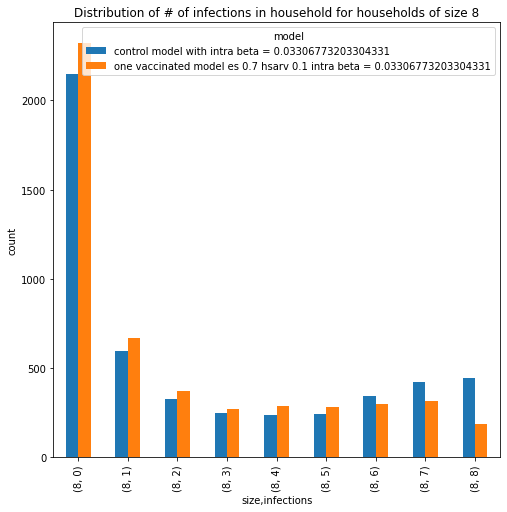

In [12]:
# --- Run the study some number of times ---
trials = 100
vax_df, control_df = one_vax_study.run_trials(trials, arms="both") # we collect the results of our study in two Pandas DataFrames. For more information see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
utilities.make_bar_chart(pd.concat([vax_df, control_df])) # look at histograms of infections to check for coherence or interesting results

In [13]:
# --- Analyze the results ---

vax_df

,size,model,infections,num vaccinated,vaccinated infected,unvaccinated infected,num unvaccinated,trialnum
0,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,2,1.0,0,2,7.0,0
1,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,2,1.0,0,2,7.0,0
2,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,0
3,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,4,1.0,0,4,7.0,0
4,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,0
...,...,...,...,...,...,...,...,...
4995,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,99
4996,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,99
4997,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,1,1.0,0,1,7.0,99
4998,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,99


In [14]:
# mean (over trials) number of placebo recepients who get infected
mean = control_df[control_df["vaccinated infected"] > 0].groupby("trialnum")["vaccinated infected"].count().mean()
total = control_df.groupby("trialnum")["num vaccinated"].count().mean()
print("Percent of placebo reccepients who were infected")
print(100 * mean / total)

# mean (over trials) number of vaccinated recepients who get infected
mean = vax_df[vax_df["vaccinated infected"] > 0].groupby("trialnum")["vaccinated infected"].count().mean() 
total = vax_df.groupby("trialnum")["num vaccinated"].count().mean()
print("Percent of vacccine reccepients who were infected")
100 * mean / total

Percent of placebo reccepients who were infected
31.18
Percent of vacccine reccepients who were infected


13.06

In [15]:
print("Mean percent of individuals infected in vaccinated households by household size")
infections = vax_df.groupby("size")["infections"].mean()
size = vax_df.groupby("size")["size"].mean()
print(infections / size * 100)

print("Mean percent of individuals infected in unvaccinated households by household size")
infections = control_df.groupby("size")["infections"].mean()
size = control_df.groupby("size")["size"].mean()
print(infections / size * 100)

Mean percent of individuals infected in vaccinated households by household size
size
8    25.67
dtype: float64
Mean percent of individuals infected in unvaccinated households by household size
size
8    31.775
dtype: float64


## Calculating Vaccine Effects (VE)

After simulating a two-armed study (see the above work), it's important to have measures of the vaccine's effect in order to assess clinical usefulness.

Assessing a vaccine's effect on the 'true' infection dynamics is a difficult inference problem, so it's typically best to calculate a variety of summary statistics that quantify the observed vaccine's effects relative to congruent individuals in the placebo/control arm.

To describe these quantities, it's helpful to use the following language: "primary individuals" receieved the intervention directly, be it the vaccine or the placebo; "secondary individuals" did not receive the intervention but are in a household with someone who did (typically, everyone who is not primary is secondary). See the table below for the terms used to identify different groups:

|  | Vaccinated households | Control households
| ------------- |:-------------:| :-----:|
| Primary       | v,p | c,p |
| Secondary     | v,s | c,s |
| Everyone     | v | c |

This python module makes three such statistics available by default:

*  VEtotal: the vaccine's aggregate effect. Measured by comparing outcomes for all individuals in each arm.
*  VEs: the vaccine's effect on susceptibility. Measured by comparing outcomes for primary study individuals across the two arms.
*  VEcontact: the vaccine's effect on transmission. Measured by comparing outcomes for secondary individuals across the two arms.

All these quantities are calculated as $1 - RR$ where $RR$ is the risk ratio calculated between the two congruent groups named above. In other words:

$$\text{VE}_{\text{total}} = 1 - \frac{f_{v}}{f_{c}}\\
\text{VE}_{\text{s}} = 1 - \frac{f_{v,p}}{f_{c,p}}\\
\text{VE}_{\text{contact}} = 1 - \frac{f_{v,s}}{f_{c,s}}$$

where, for example, $f_{v,p}$ denotes the fraction of primary individuals in households that received vaccine (in contrast to placebo) who were infected when the study concluded.

The statistical significance of these effects is determined using [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test).

In [16]:
print("VEtotal")

vetotal_df = one_vax_study.vetotal()
vetotal_df

VEtotal
Calculating VEtotal ...
 Vaccine study named one vaccinated with:
	n_per_arm                = 50
	household sizes          = {8: 50}
	es, hsarv                = 0.700, 0.100
	vax_sus, vax_inf         = 0.300, 0.463
	seeding                  = <function seed_zero at 0x7f85763243b0>
	duration                 = 90
	net /person import prob  = 0.100
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



,VE,fisher p value
trialnum,,
0,0.432624,0.000002
1,0.358209,0.000190
2,0.260504,0.015324
3,0.351145,0.000327
4,0.080000,0.562332
...,...,...
95,0.267717,0.008892
96,-0.284404,0.021876
97,0.114754,0.309858


Means:


VE                0.175172
fisher p value    0.201384
dtype: float64

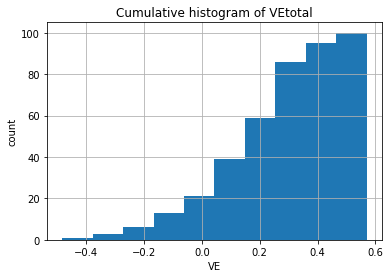

In [17]:
vetotal_df["VE"].hist(cumulative=True)
plt.title("Cumulative histogram of VEtotal")
plt.xlabel("VE")
plt.ylabel("count")
print("Means:")
vetotal_df.mean()

In [18]:
print("VEs")

ves_df = one_vax_study.ves()
ves_df

VEs
Calculating VEs ...
 Vaccine study named one vaccinated with:
	n_per_arm                = 50
	household sizes          = {8: 50}
	es, hsarv                = 0.700, 0.100
	vax_sus, vax_inf         = 0.300, 0.463
	seeding                  = <function seed_zero at 0x7f85763243b0>
	duration                 = 90
	net /person import prob  = 0.100
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



,VE,fisher p value
trialnum,,
0,0.761905,0.000473
1,0.666667,0.009115
2,0.705882,0.007005
3,0.400000,0.241424
4,0.300000,0.595463
...,...,...
95,0.562500,0.055865
96,0.466667,0.153062
97,0.437500,0.165154


Means:


VE                0.567588
fisher p value    0.141650
dtype: float64

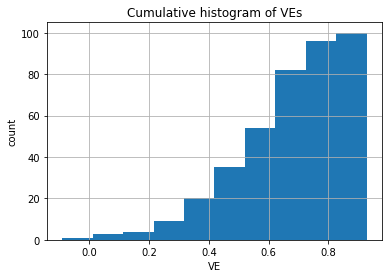

In [19]:
ves_df["VE"].hist(cumulative=True)
plt.title("Cumulative histogram of VEs")
plt.xlabel("VE")
plt.ylabel("count")
print("Means:")
ves_df.mean()

In [20]:
print("VEs")

vecontact_df = one_vax_study.vecontact()
vecontact_df

VEs
Calculating VEcontact ...
 Vaccine study named one vaccinated with:
	n_per_arm                = 50
	household sizes          = {8: 50}
	es, hsarv                = 0.700, 0.100
	vax_sus, vax_inf         = 0.300, 0.463
	seeding                  = <function seed_zero at 0x7f85763243b0>
	duration                 = 90
	net /person import prob  = 0.100
	importation rate         = 0.001
	hsar                     = 0.200
	household_beta           = 0.033
	min r0, max r0           = 1.620, 1.620



,VE,fisher p value
trialnum,,
0,0.375000,0.000198
1,0.310345,0.003161
2,0.186275,0.122729
3,0.344828,0.000927
4,0.055556,0.727043
...,...,...
95,0.225225,0.043528
96,-0.404255,0.002741
97,0.066038,0.618307


Means:


VE                0.119057
fisher p value    0.254032
dtype: float64

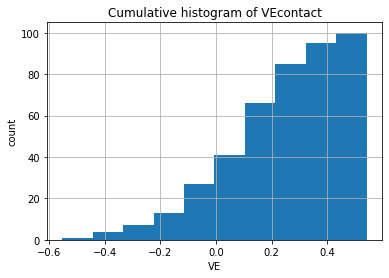

In [21]:
vecontact_df["VE"].hist(cumulative=True)
plt.title("Cumulative histogram of VEcontact")
plt.xlabel("VE")
plt.ylabel("count")
print("Means:")
vecontact_df.mean()

## Power calculations

After measuring a vaccine effect in a number of simulated trials, it's important to get a measure of power -- the probability that a real effect would be detected by a study if the effect is present.

The power is conditioned on two choices:

*   p-value: the cutoff for statistical significance used to conclude if an effect was detected.
*   Effect size threshold: the magnitude of VE that must be reached to conclude the study a success.



In [28]:
# we call the module's power function for VEtotal at 99% significance looking for effects of any size
vaccine.power(vetotal_df, 0.01, threshold=0.0)

Calculating power


0.4

In [27]:
# we call the module's power function at 95% significance looking for effects of VEs >= 0.3
vaccine.power(ves_df, 0.05, threshold=0.3)

Calculating power


0.56

To see if a study design is feasible, it's helpful to look at power as a function of sample size.

In [44]:
# --- Setting parameters for a VaccineStudy ---

# no n_per_arm specified because we want it to vary
sizes = [4,5,6,7,8] 


hsar = 0.2 # the desired household sar
hsarv = 0.1 # the hsar calculated in reference to vaccinated individuals (therefore encoding vaccine effect on infectivity)

es = 0.5 # = 1 - the relative chance per contact of an infection passing to a vaccinated individual

# Duration of the study and importation rate
duration = 90 # days
importation_probability_over_study = 0.1 # probability an unvaccinateed individual becomes infected over the whole course of the study

# Specifying the vaccination protocol. Common methods such as vaccinating one individual, a fraction of individuals, or a fixed number of individuals are made available in vaccine.py
vaccination_method = vaccine.vaccinate_one
#vaccination_method = functools.partial(vaccinate_fraction,fraction_vaccinated=0.5)

In [ ]:
n_axis = np.linspace(100, 2000, 35)

threshold = 0.0
fisher_p  = 0.05


vec_pow = []
vet_pow = []
ves_pow = []
for n in n_axis:
    study = vaccine.VaccineStudy("one vaccinated", n, sizes, hsar, es, (hsarv, 'hsarv'), duration, importation_probability_over_study, vaccination_method)
    trials = 100
    vax_df, control_df = study.run_trials(trials)

    vecontact_power = vaccine.power(study.vecontact(), fisher_p, threshold=threshold)
    vetotal_power   = vaccine.power(study.vetotal(), fisher_p, threshold=threshold)
    ves_power       = vaccine.power(study.ves(), fisher_p, threshold=threshold)

    vec_pow.append(vecontact_power)
    vet_pow.append(vetotal_power)
    ves_pow.append(ves_power)

vec_pow = pd.Series(vec_pow)
vec_pow.name="VEcontact"
vet_pow = pd.Series(vet_pow)
vet_pow.name="VEtotal"
ves_pow = pd.Series(ves_pow)
ves_pow.name="VEs"

In [46]:
pow_df = pd.concat([vec_pow, vet_pow, ves_pow], axis=1)
pow_df.index = n_axis

Text(0, 0.5, 'Power')

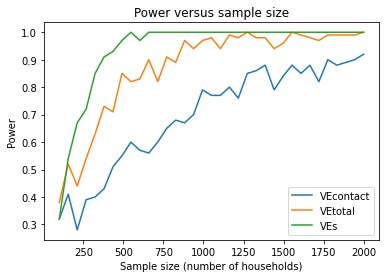

In [48]:
#pow_df.index = n_axis
pow_df.plot()
plt.title("Power versus sample size")
plt.xlabel("Sample size (number of households)")
plt.ylabel("Power")
#pow_df

# Making a git commit from changes to python backend

To save this notebook use `File > Save a copy in Github`

In [ ]:
!git add -A
!git status
!git diff --cached

In [47]:
!git config --global user.email ""
!git config --global user.email "Thayer"

In [48]:
message = input("Commit message? ")

!git commit -m "{message}"

Commit message? Resolving merge conflict
[main 9fdf852] Resolving merge conflict


# Pushing upstream or pulling changes

Use `File > Save a copy in Github` to save this notebook. Use these cells to commit changes to the python backend or pull changes from the origin.

In [ ]:
!git remote set-url origin https://{git_token}@github.com/{repo_owner}/{repository}

In [49]:
!git pull
!git commit -m 'Merged'

Already up to date.
On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
!git push

Counting objects: 8, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 1.12 KiB | 383.00 KiB/s, done.
Total 8 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 4 local objects.
To https://github.com/tanderson11/covid_households
   f7ed928..134634f  main -> main
